Effect of Packet length to the spectrum

In [1]:
# add to path to acces cli 
import sys
import os

sys.path.insert(0, os.path.abspath("../cli"))
print(sys.path)

import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq

plt.rcParams['figure.figsize'] = (10, 10)  # Increases figure size
# from cli.simulation.utils import * # TODO fix
from simulation.sonar import Sonar
from simulation.utils import Bottom, positions_line, positions_half_circle
from simulation import plotting
from examples.seismic import Receiver, WaveletSource
from scipy import signal

['/home/bgd54/forge/devito/sonar-FWI/cli', '/home/bgd54/forge/devito/sonar-FWI/cli', '/home/bgd54/forge/devito/sonar-FWI/cli', '/usr/bin', '/home/bgd54/forge/devito/sonar-FWI/cli', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/bgd54/.local/lib/python3.10/site-packages', '/usr/lib/python3.10/site-packages', '/home/bgd54/.local/share/nvim/site/pack/packer/start/vim-jukit/helpers']


In [ ]:
def setup_beam(src, u, source_distance, alpha, dt, c):
    ns = src.coordinates.data.shape[0]
    for i in range(ns):
        latency = -np.cos(np.deg2rad(alpha)) * (i * source_distance / c)
        src.data[:, i] = np.roll(src.data[:, i], int(latency / dt))
    u.data.fill(0)

Setting up parameters of the simulation

In [ ]:
domain_size = (60,30) # (m, m)
f0 = 5. # kHz
v_env = 1.5 # km/s
ns = 128

source_distance = 0.02 # m
center_pos_rel = (.5, 0.) 
cy = (ns - 1) / 2 * source_distance

spacing: (0.1, 0.1), size: 601 x 301, (60.00000089406967, 30.000000447034836)
dt: 0.01889999955892563 t: 60.38411966539787
rec_pos {0.5, 0.042333333333333334} -> {30.0, 1.27} cp: (30.000000447034836, 1.2700000189244747), sdist = 0.02
flat o: False


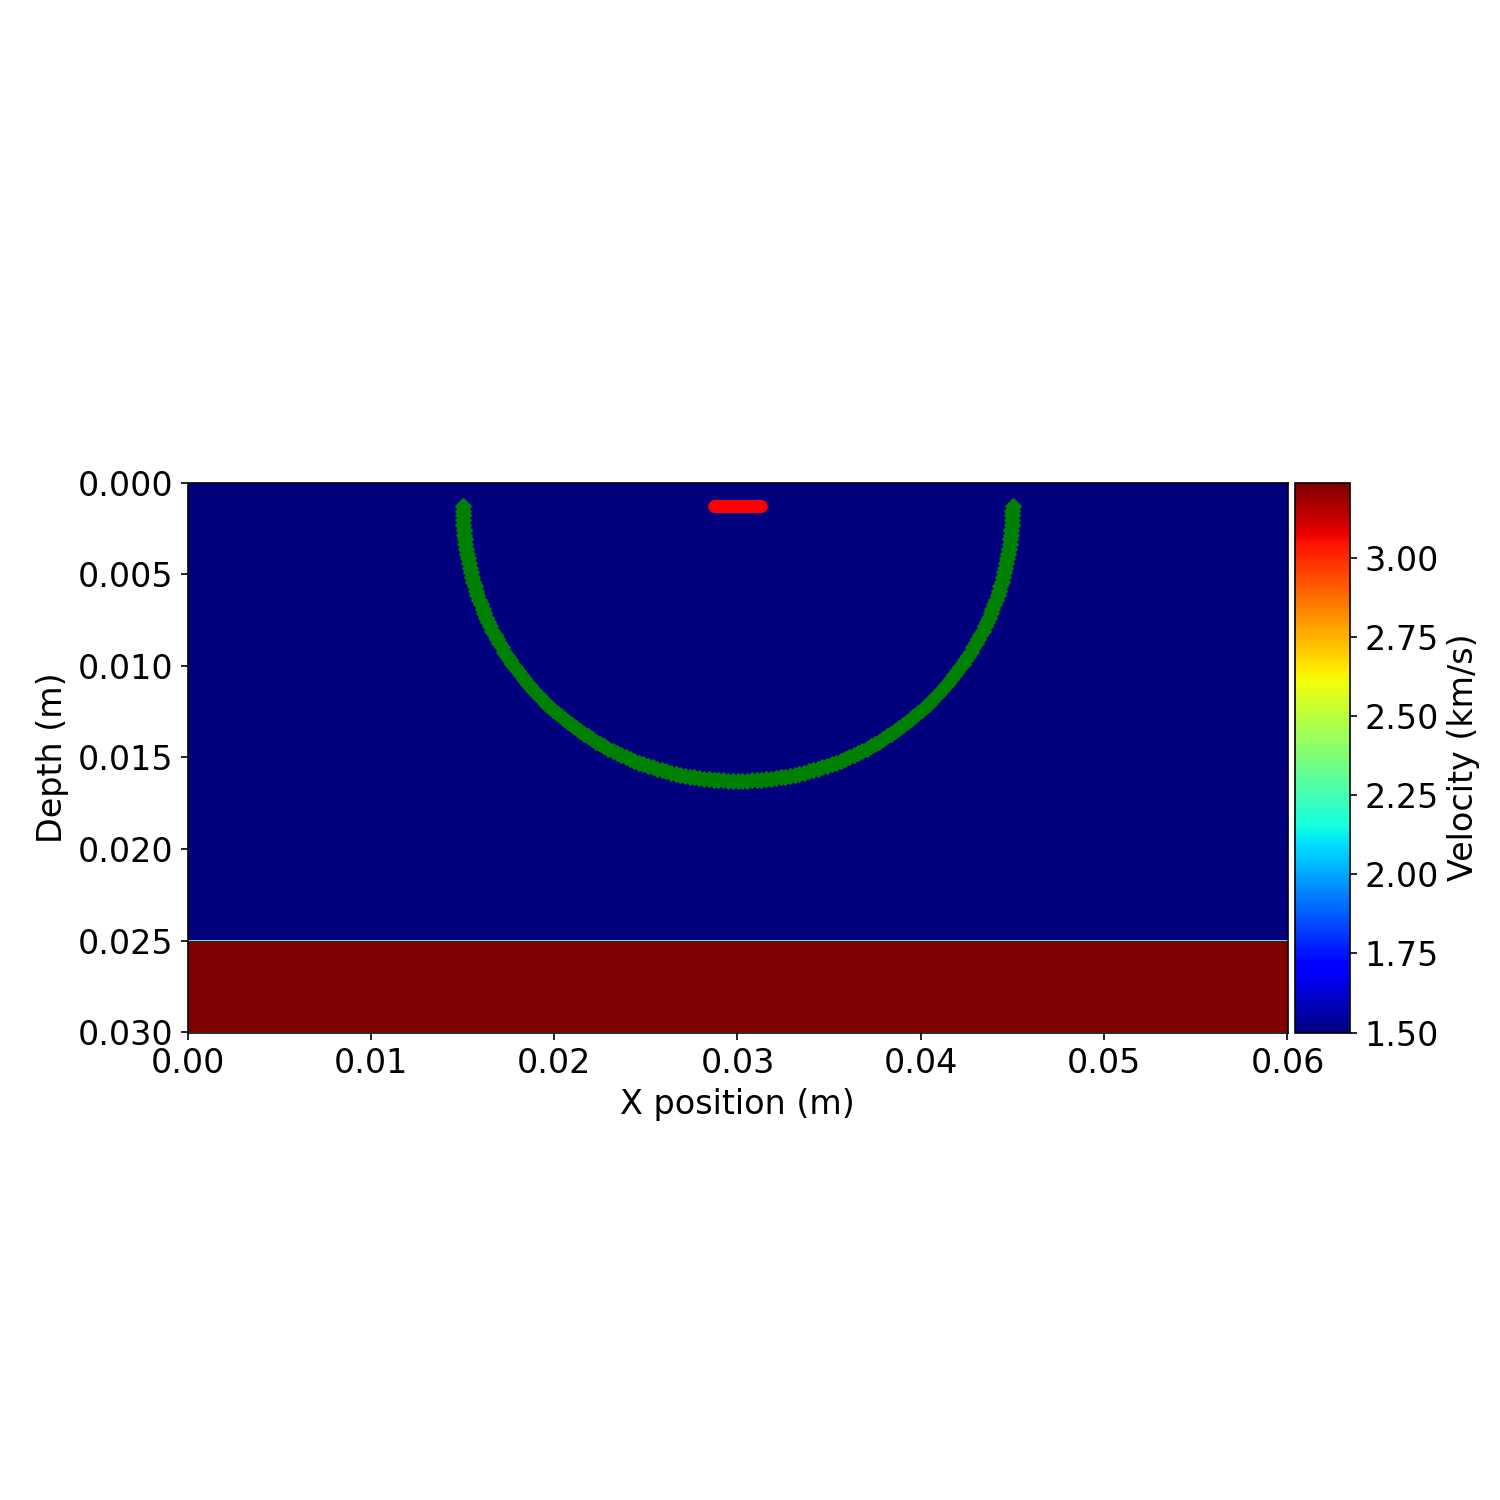

In [2]:
s = Sonar(
    domain_size[0],
    domain_size[1],
    f0,
    v_env,
    ns,
    center_pos_rel[0],
    center_pos_rel[1],
    Bottom.flat,
    source_distance,
    # rec_positions=positions_line(domain_size[0], 15.0, 128),
    rec_positions=positions_half_circle(15., 30., cy),
)

s.plot_model(plotting.PlotType.model)

In [3]:
setup_beam(s.src, s.u, source_distance, 90.0, s.model.critical_dt, v_env)
s.op(time=s.time_range.num - 2, dt=s.model.critical_dt)

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.20546500000000534, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.019411000000000327, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.009730000000000225, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

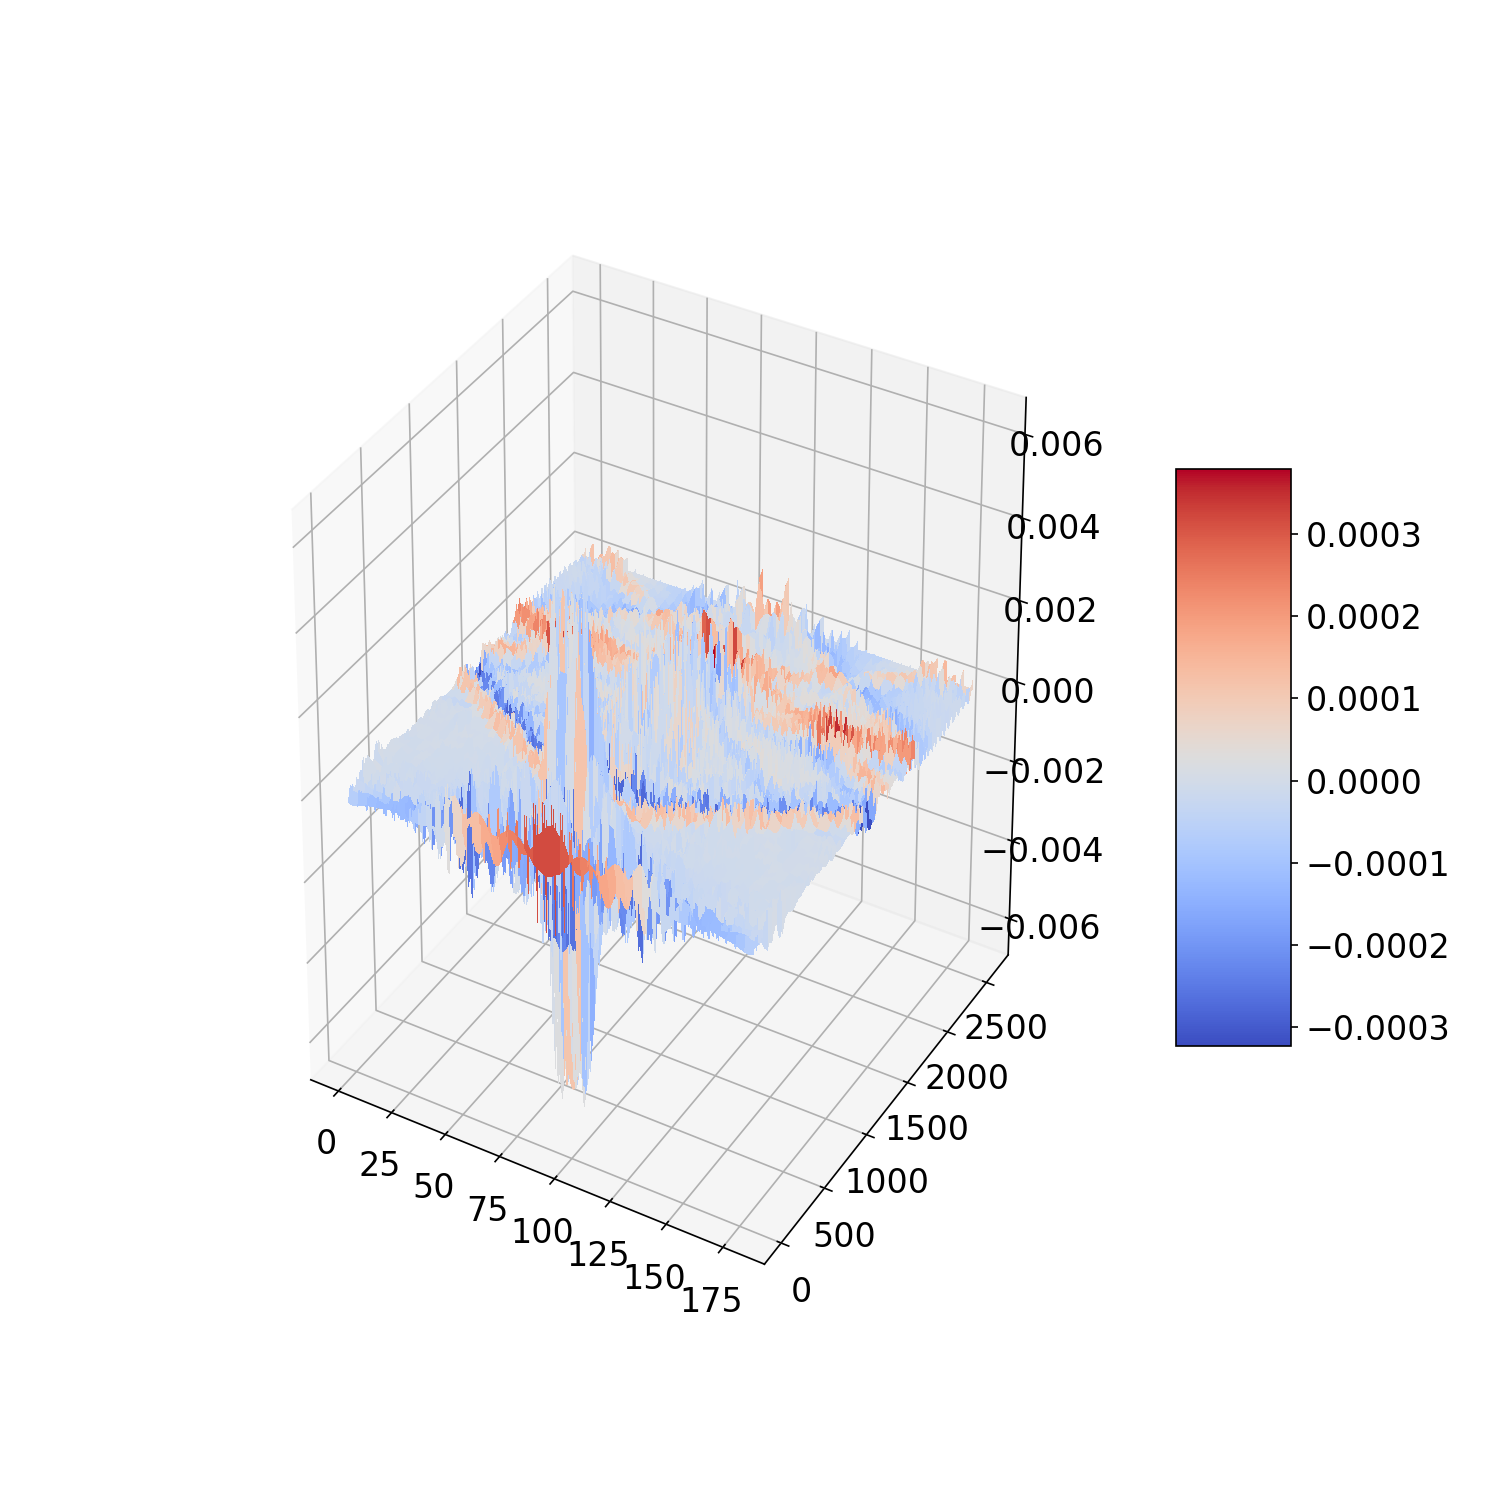

In [4]:
plotting.plot_shotrecord2(s.rec.data)

In [ ]:
class MultiFrequencySource(WaveletSource):
    """
    A source object that encapsulates everything necessary for injecting a
    sine source into the computational domain.

    Returns:
        The source term that will be injected into the computational domain.
    """

    def __init_finalize__(self, *args, **kwargs):
        self.alphas = kwargs.get("alphas")
        self.packet_l = kwargs.get("packet_l") or 128
        super(MultiFrequencySource, self).__init_finalize__(*args, **kwargs)

    # property returning all wavelets with different frequencies to combine with the latency profile
    @property
    def wavelets(self):
        assert self.f0.shape == self.alphas.shape
        t0 = self.t0 or np.min(1/self.f0)
        a = self.a or 1
        t = self.time_values - t0
        r = 2 * np.pi * self.f0[:, np.newaxis] * t
        wave = a * np.sin(r) + a*np.sin((self.packet_l-1)*(r+np.pi)/self.packet_l)
        for i, f in enumerate(self.f0):
            wave[i, np.searchsorted(t, self.packet_l * 2 / f) :] = 0

        return wave

    def apply_latency_profile(self, c):
        # compute the latency shifts for each angle - wavelet pair and apply them
        # to set the data for each source
        assert all(map(lambda x: x[1] == self.coordinates.data[0, 1], self.coordinates.data))
        source_distances = src.coordinates.data[:, 0] - self.coordinates.data[0, 0]
        latencies = -np.cos(np.deg2rad(self.alphas[:, np.newaxis])) * (source_distances / c)
        latencies_tick = (latencies / self.time_range.step).astype(int)
        latencies_tick = latencies_tick - np.min(latencies_tick)
        src.data.fill(0)
        wavelets = self.wavelets
        for i in range(self.data.shape[1]): 
            for j in range(latencies_tick.shape[0]):
                src.data[:, i] += np.roll(wavelets[j, :], latencies_tick[j, i])
                


    @property
    def wavelet(self):
        f0 = self.f0[0]
        t0 = self.t0 or 1 / f0
        a = self.a or 1
        r = 2 * np.pi * f0 * (self.time_values - t0)
        wave = a * np.sin(r) + a * np.sin((self.packet_l-1)*(r + np.pi) / self.packet_l)
        wave[np.searchsorted(self.time_values, 4 * 2 / f0) :] = 0
        return wave

    @property
    def signal_packet(self):
        return self.wavelet[: np.searchsorted(self.time_values, 4 * 2 / self.f0[0])] # TODO

[5 6 7]
TimeAxis: start=0, stop=60.3855, step=0.0189, num=3196


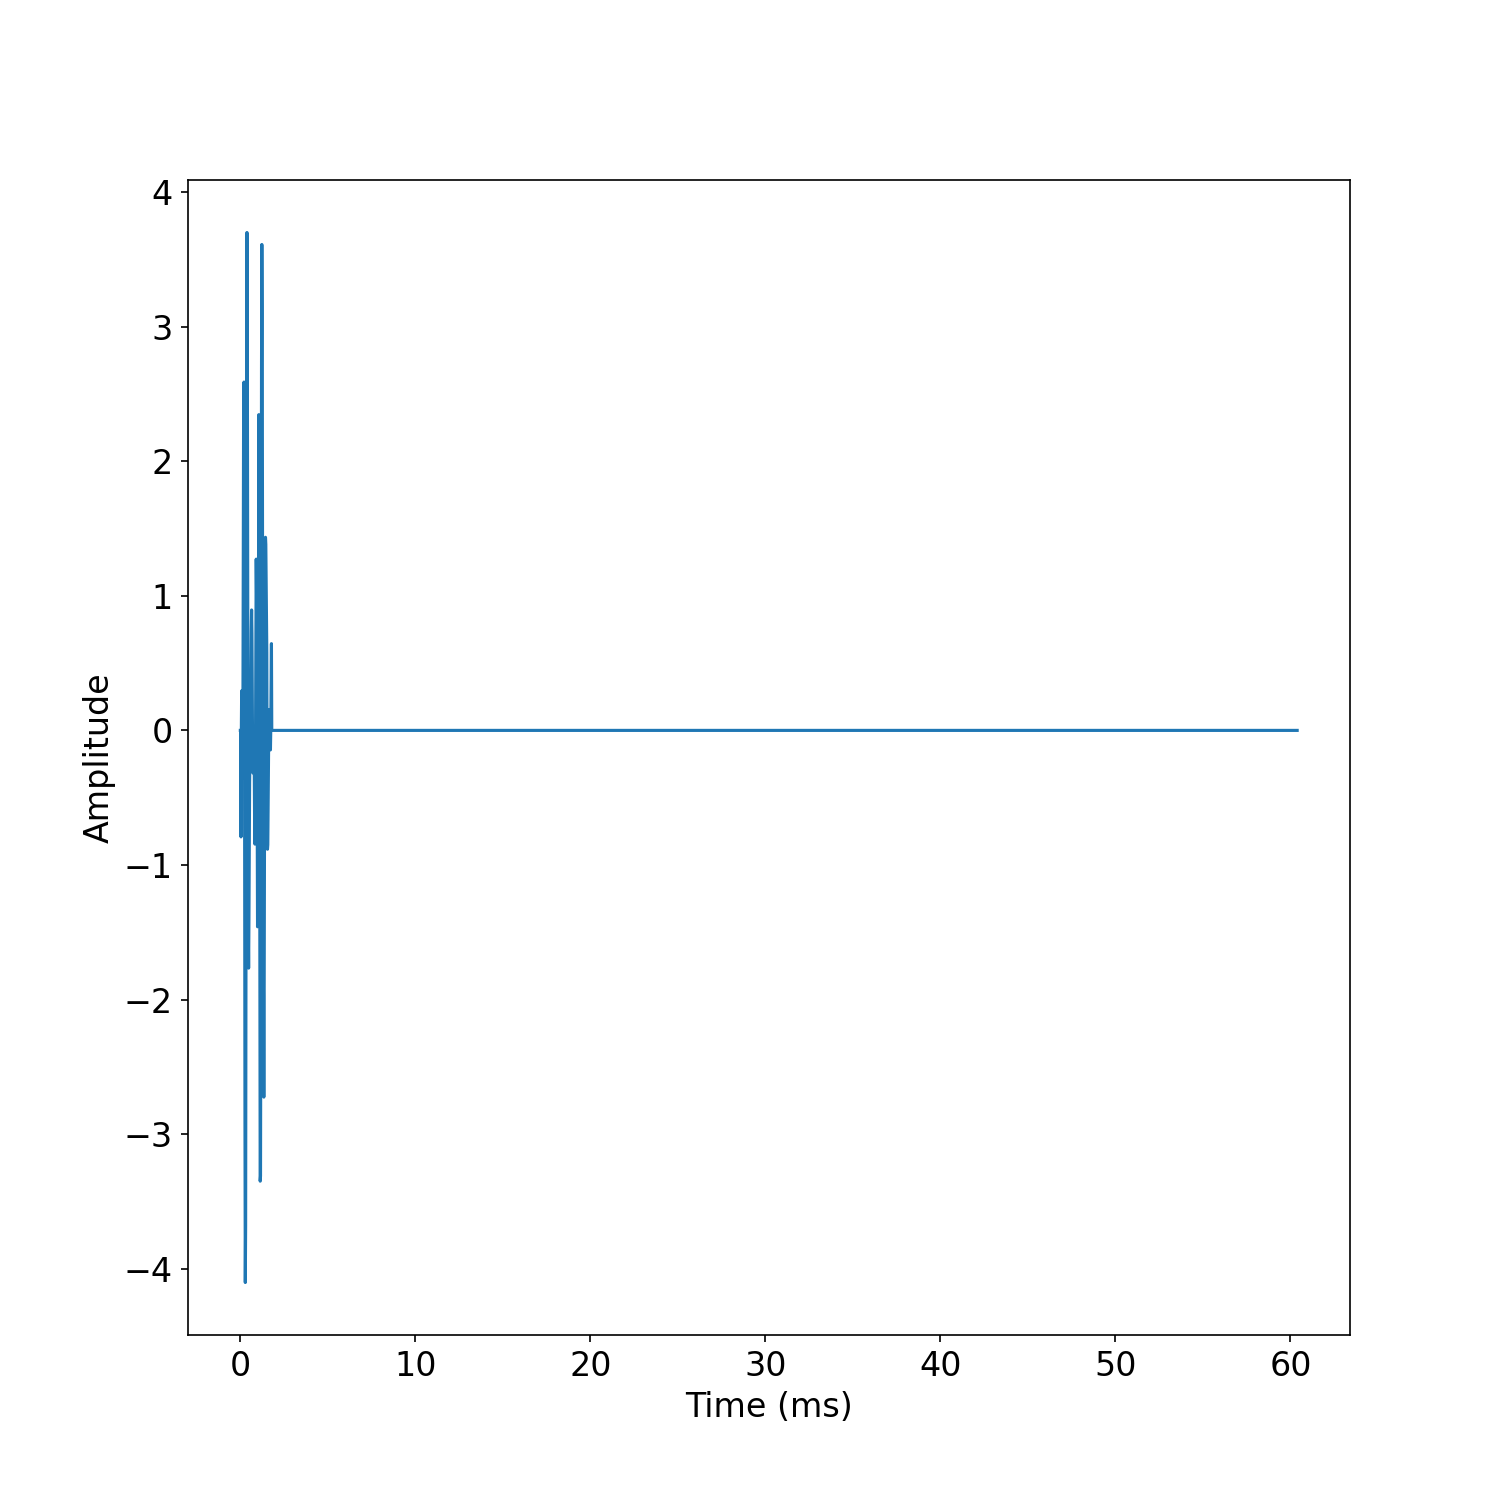

In [5]:
f = np.arange(5, 8, 1)
time_values = s.time_range
ns = 4
print(f)
print(time_values)
src = MultiFrequencySource(
    name="src",
    grid=s.model.grid,
    npoint=ns,
    f0=f,
    alphas=np.arange(f.shape[0]) * 45,
    packet_l=4,
    time_range=time_values,
)
src.coordinates.data[:, :] = np.array([15 - source_distance * ns / 2, cy]) + positions_line(ns*source_distance, source_distance, ns)
src.apply_latency_profile(v_env)
src.show()

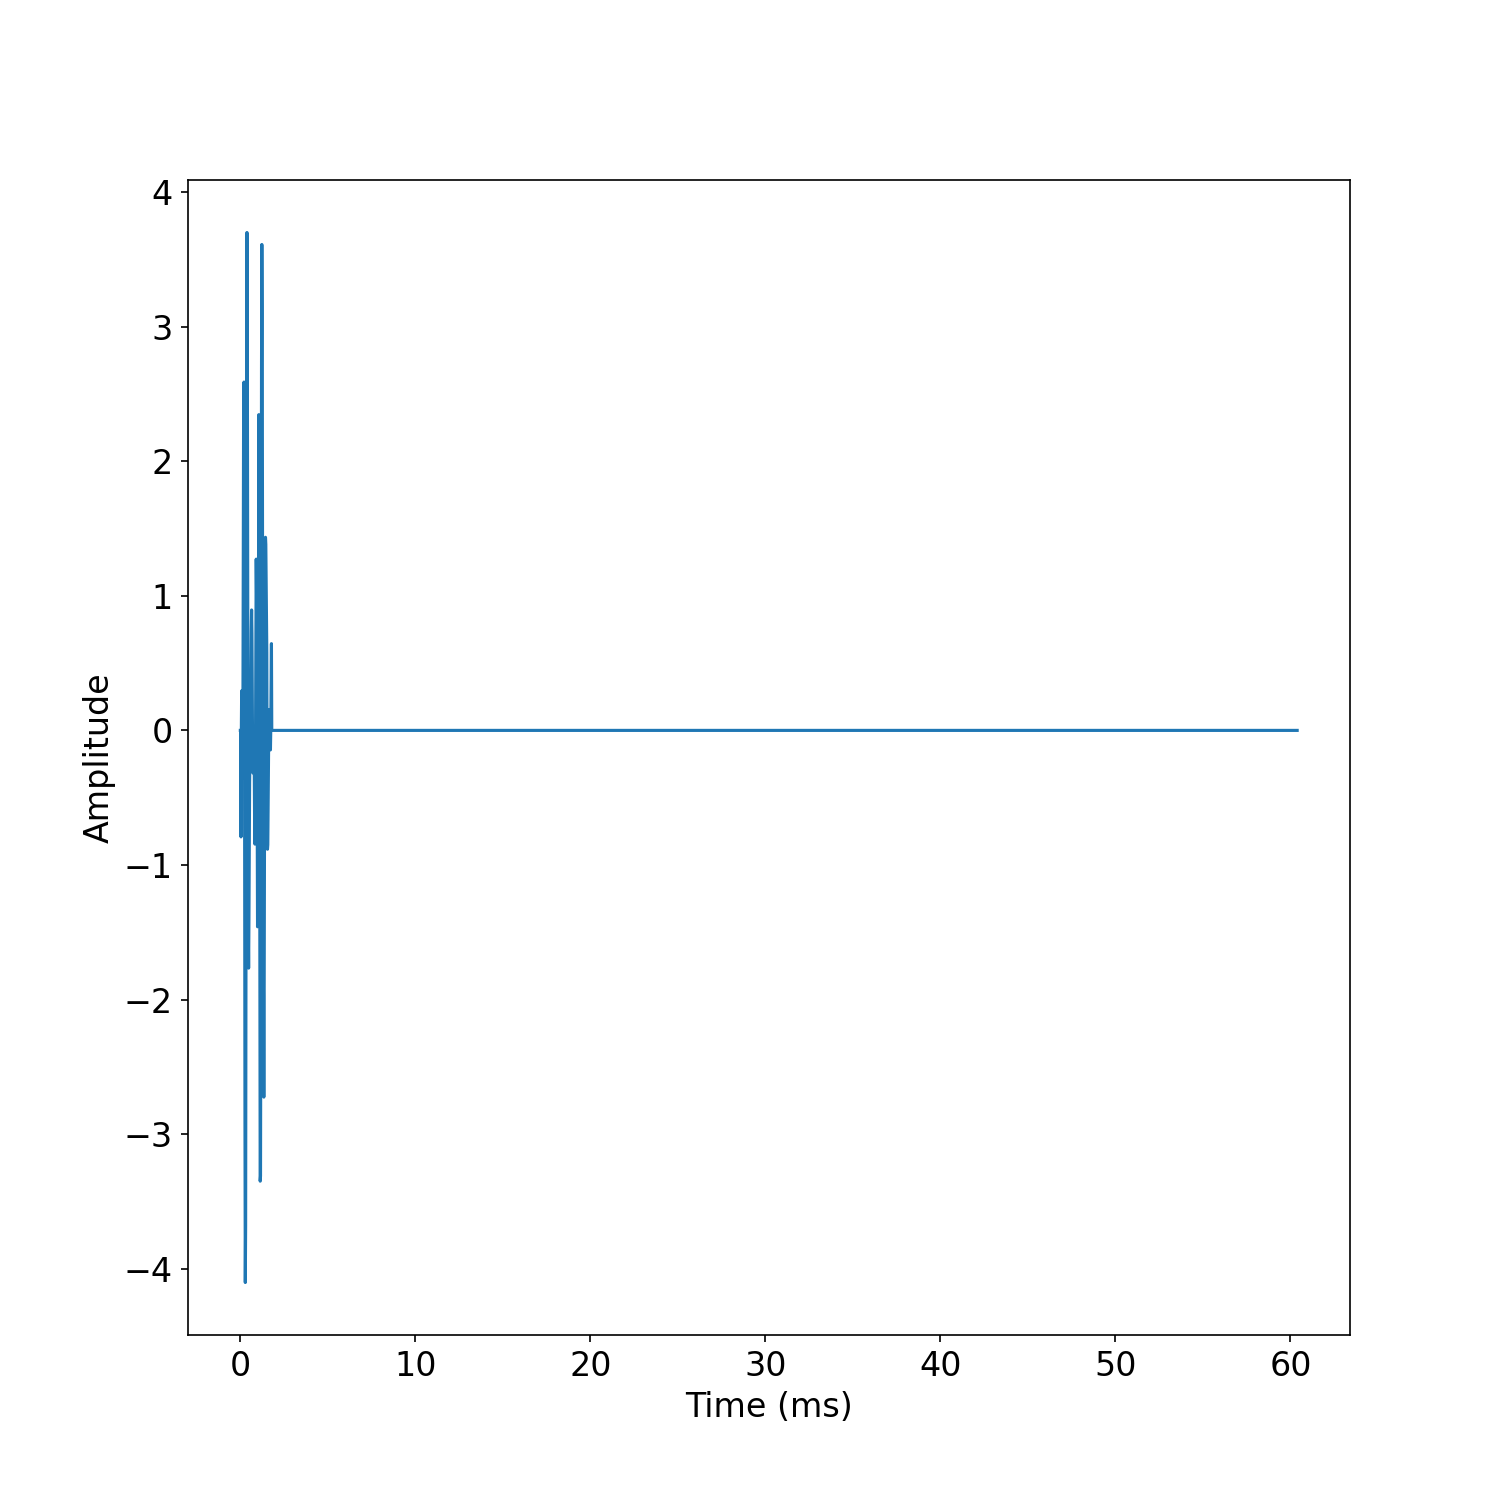

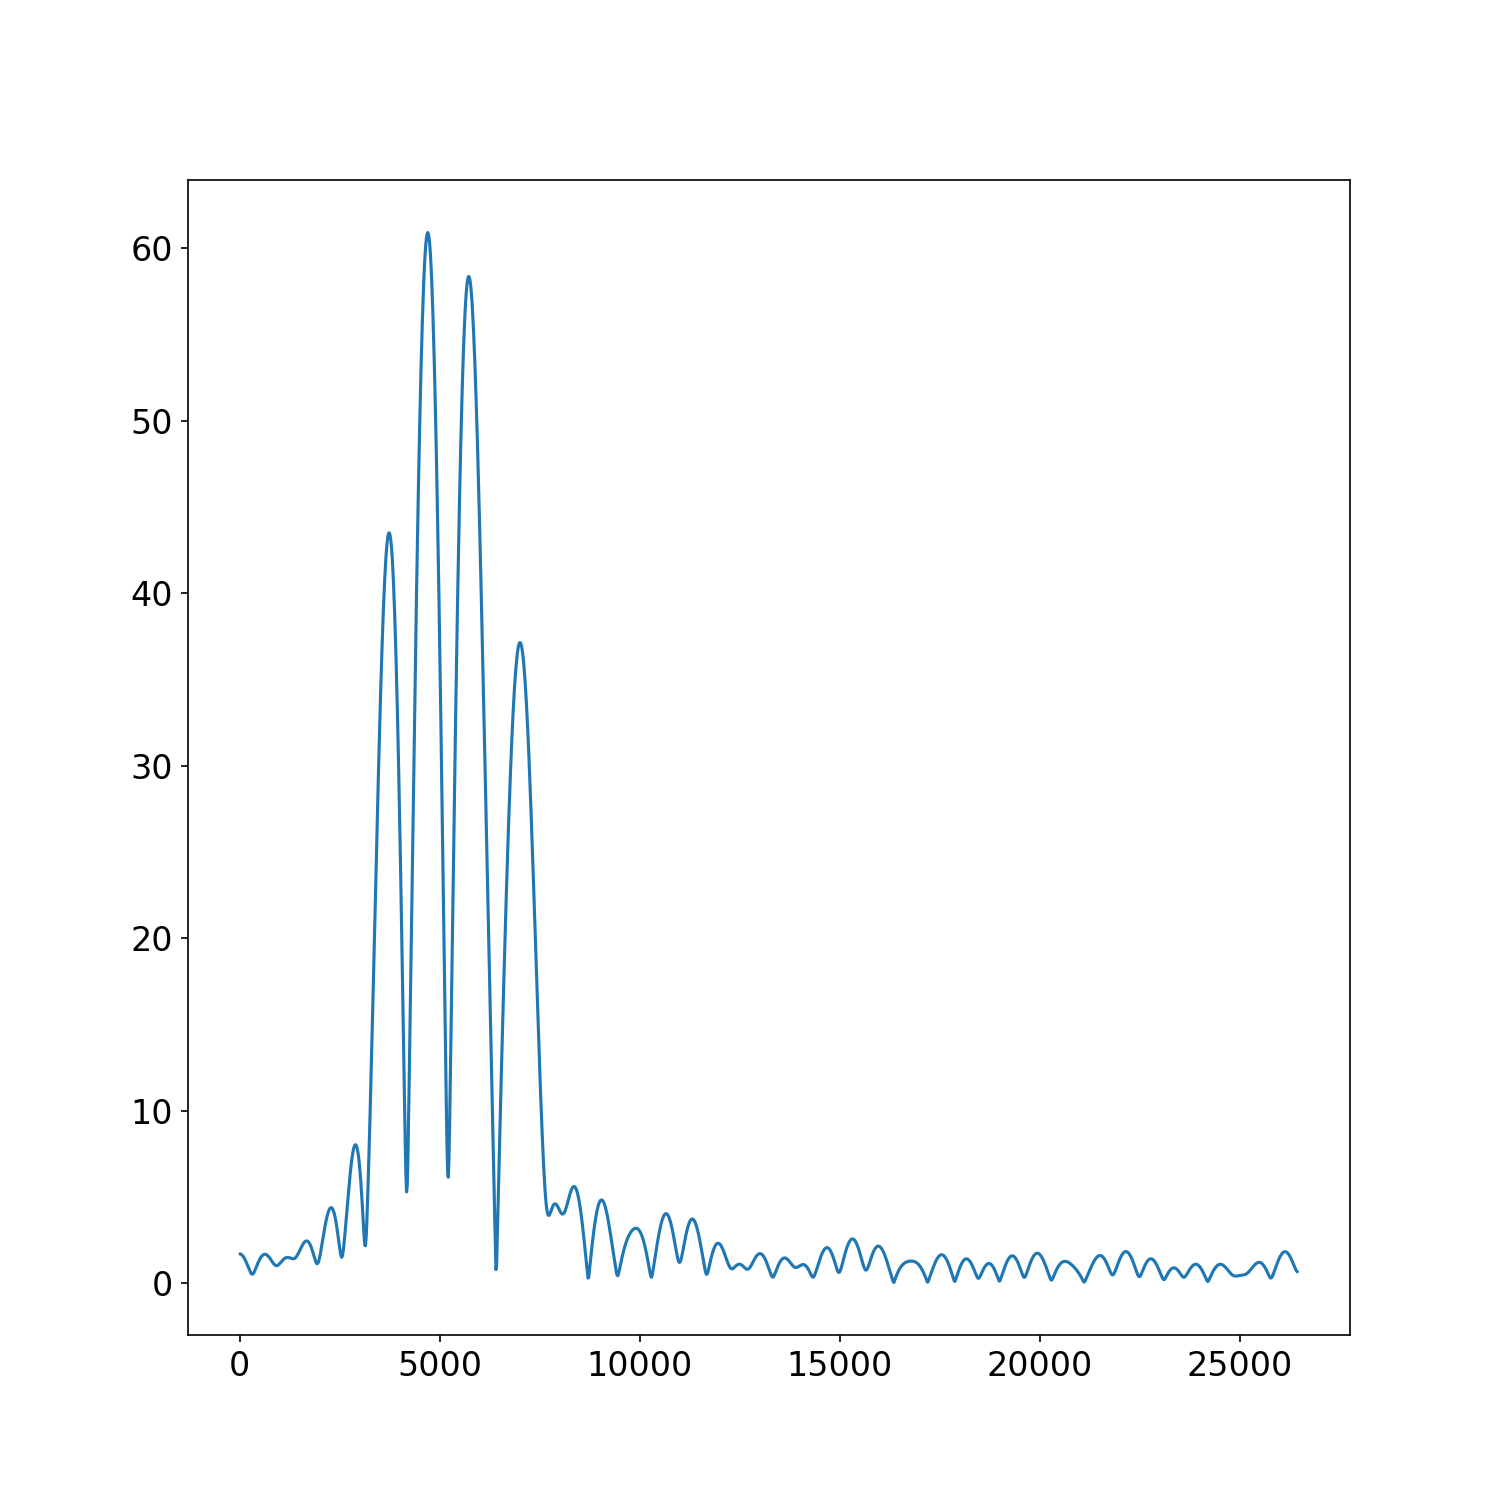

In [6]:
wave = src.data[:, 0]

plt.plot(time_values.time_values, wave)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()


yf = fft(wave)
xf = fftfreq(len(time_values.time_values), s.model.critical_dt*1e-3)

on = list(map(lambda x: x > 0 and x < 400e3, xf))

plt.plot(xf[on], np.abs(yf[on]))
plt.show()

sampling freq 52.91005414482904


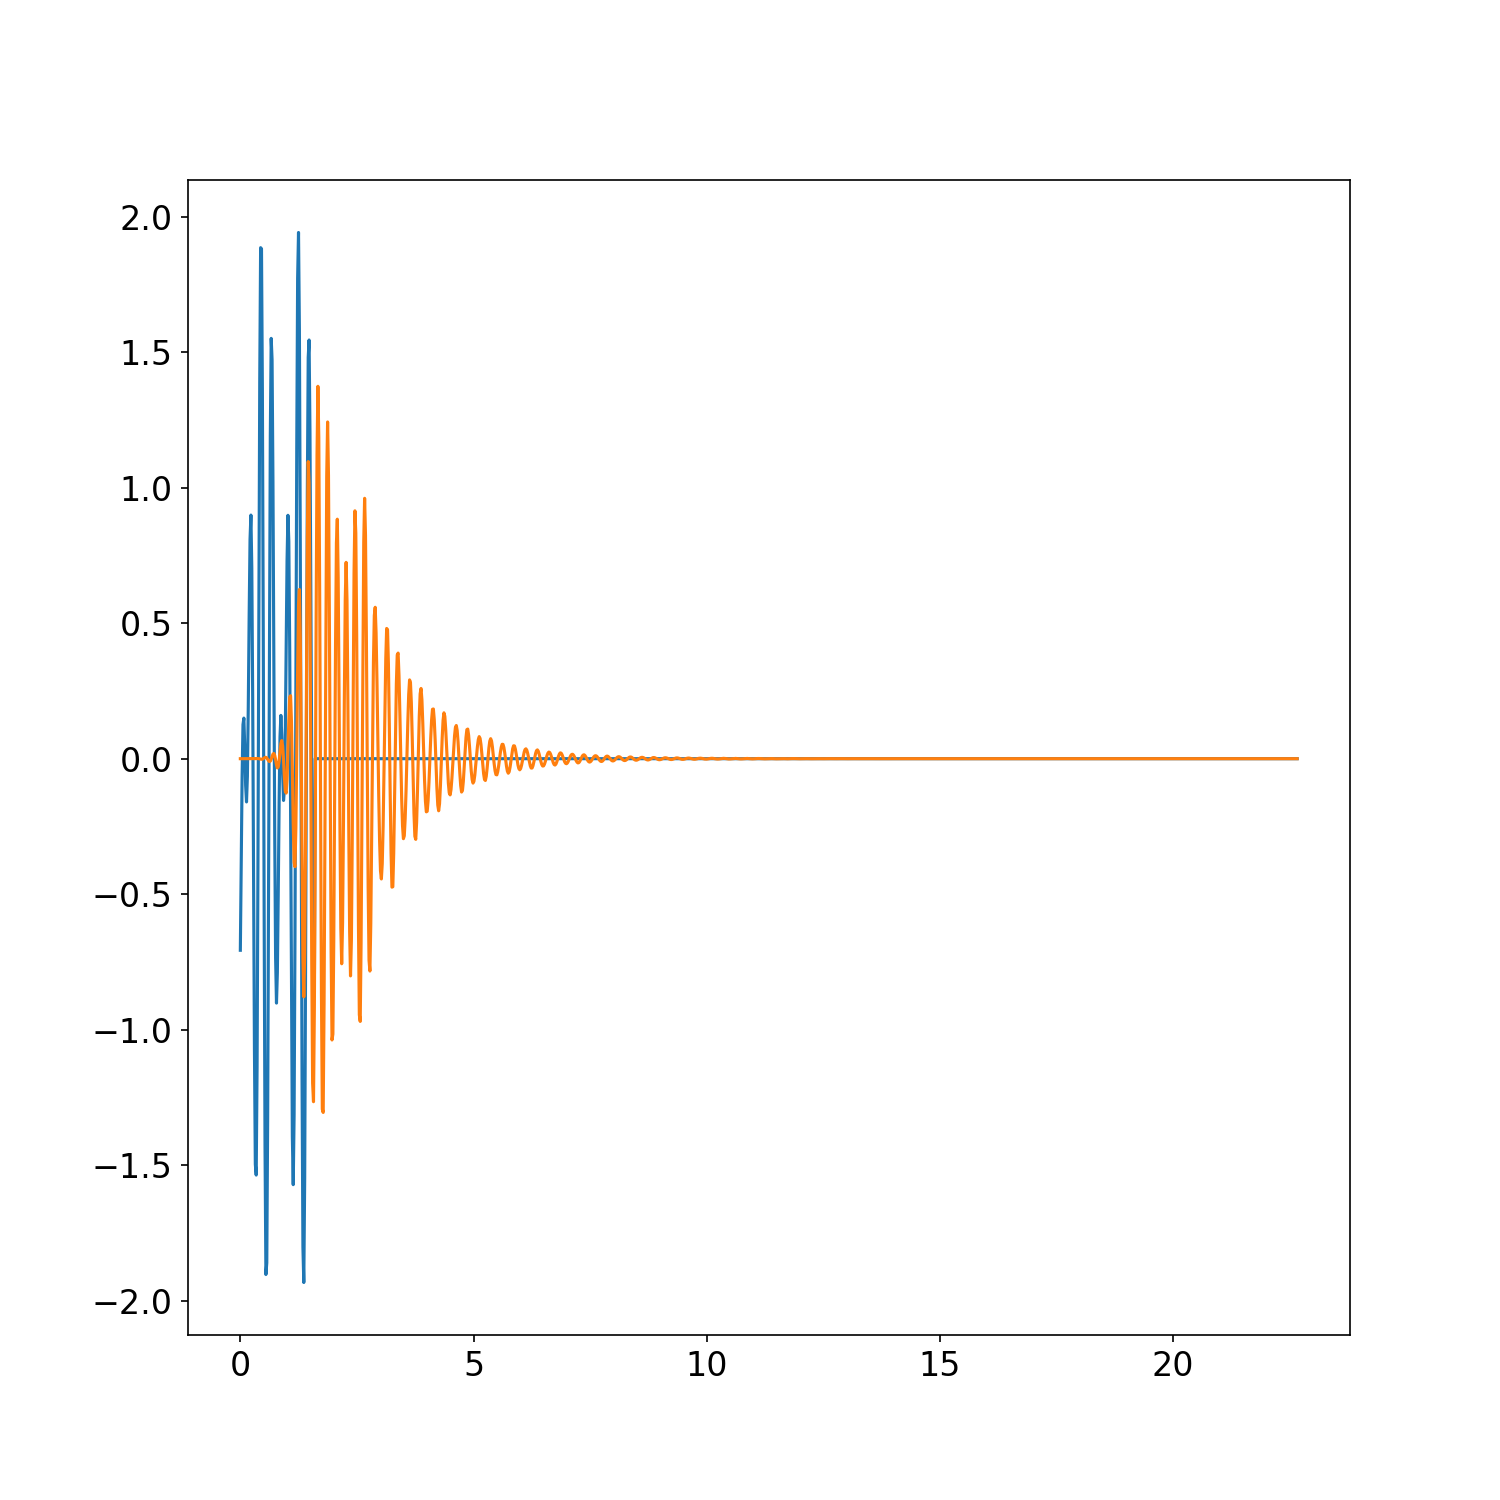

In [7]:
f0 = 8*1e3
dt = s.model.critical_dt
print('sampling freq ' + str(1/dt))
bandpass = signal.butter(10, [4,6], 'bandpass', fs=1/dt, output='sos')

time = time_values.time_values[0:2*600]
to_filter = s.src.data[:2*600,0]
#time = src.time_values[:cut]
#to_filter = rec.data[:cut,64]
filtered = signal.sosfilt(bandpass, to_filter)
plt.figure()
plt.plot(time,to_filter)
plt.plot(time,filtered)